# DSCI 617 – Group Project
## Lahman Baseball Database
**Alexander Bartel, Mustafa Khan**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

spark = SparkSession.builder.getOrCreate()

## Section A – Load and Prepare Data 
In this section we will load the datasets into Spark and prepare them for analysis.

### A.1 – Load Data 
In this sub-section we will load the four datasets we will analyze first into dataframes, and count the number of records in each dataset.

In [0]:
people = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .option('inferSchema', True)
    .csv('/FileStore/tables/lahman/People.csv')
)

batting = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .option('inferSchema', True)
    .csv('/FileStore/tables/lahman/Batting.csv')
)

teams = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .option('inferSchema', True)
    .csv('/FileStore/tables/lahman/Teams.csv')
)

franchises = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .option('inferSchema', True)
    .csv('/FileStore/tables/lahman/TeamsFranchises.csv')
)

print(f'{"Number of records in people:":<33}{people.count():>6}\n{"Number of records in batting:":<33}{batting.count():>6}\n{"Number of records in teams:":<33}{teams.count():>6}\n{"Number of records in franchises:":<33}{franchises.count():>6}')

Number of records in people: 20150
Number of records in batting: 108789
Number of records in teams: 2955
Number of records in franchises: 120

### A.2 – The People Table 
In this sub-section we will explore the people dataset; we will look at the different columns and determine if there are missing values, and if so, how many for each column.

#### Columns
In the next cell we will print out the column names for the people dataframe.

In [0]:
print(people.columns)

['playerID', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry', 'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay', 'deathCountry', 'deathState', 'deathCity', 'nameFirst', 'nameLast', 'nameGiven', 'weight', 'height', 'bats', 'throws', 'debut', 'finalGame', 'retroID', 'bbrefID']

#### Looking at the Data
In the next cell we will show the first five rows of the columns of interest in the people dataframe.

In [0]:
people.select('playerID', 'nameFirst', 'nameLast', 'weight', 'height').show(5)

+---------+---------+--------+------+------+
 playerID|nameFirst|nameLast|weight|height|
+---------+---------+--------+------+------+
aardsda01| David| Aardsma| 215| 75|
aaronha01| Hank| Aaron| 180| 72|
aaronto01| Tommie| Aaron| 190| 75|
 aasedo01| Don| Aase| 190| 75|
 abadan01| Andy| Abad| 184| 73|
+---------+---------+--------+------+------+
only showing top 5 rows

#### Number of Missing Values
In the next cell we will print out the number of records that have missing value(s).

In [0]:
print(f'The number of records with missing values in the people dataframe is: {people.count() - people.dropna().count()}') 

The number of records with missing values in the people dataframe is: 11819

#### Missing Values by Column
In the next cell we will count the number of missing values for each column in the dataframe.

In [0]:
N = people.count()
# looping over first, then last half of dataframe and counting missing values for each column
people.select([expr(f'{N} - COUNT({c}) AS {c}') for c in people.columns[:12]]).show()
people.select([expr(f'{N} - COUNT({c}) AS {c}') for c in people.columns[12:]]).show()

+--------+---------+----------+--------+------------+----------+---------+---------+----------+--------+------------+----------+
playerID|birthYear|birthMonth|birthDay|birthCountry|birthState|birthCity|deathYear|deathMonth|deathDay|deathCountry|deathState|
+--------+---------+----------+--------+------------+----------+---------+---------+----------+--------+------------+----------+
 0| 114| 282| 423| 61| 534| 174| 10232| 10233| 10234| 10237| 10287|
+--------+---------+----------+--------+------------+----------+---------+---------+----------+--------+------------+----------+

+---------+---------+--------+---------+------+------+----+------+-----+---------+-------+-------+
deathCity|nameFirst|nameLast|nameGiven|weight|height|bats|throws|debut|finalGame|retroID|bbrefID|
+---------+---------+--------+---------+------+------+----+------+-----+---------+-------+-------+
 10243| 37| 0| 37| 816| 736|1180| 976| 199| 199| 54| 7|
+---------+---------+--------+---------+------+------+----+------+-----+---------+-------+-------+

### A.3 – The Batting Table 
In this sub-section we will explore the batting dataset; we will look at the different columns and determine if there are missing values, and if so, how many for each column. We will also need to address missing values by replacing them with 0 for this dataset.

#### Columns
In the next cell we will print out the column names for the batting dataframe.

In [0]:
print(batting.columns)

['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']

#### Looking at the Data
In the next cell we will show the first five rows in the batting dataframe.

In [0]:
batting.show(5)

+---------+------+-----+------+----+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+
 playerID|yearID|stint|teamID|lgID| G| AB| R| H| 2B| 3B| HR|RBI| SB| CS| BB| SO| IBB| HBP| SH| SF|GIDP|
+---------+------+-----+------+----+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+
abercda01| 1871| 1| TRO| NA| 1| 4| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|null|null|null|null| 0|
 addybo01| 1871| 1| RC1| NA| 25|118| 30| 32| 6| 0| 0| 13| 8| 1| 4| 0|null|null|null|null| 0|
allisar01| 1871| 1| CL1| NA| 29|137| 28| 40| 4| 5| 0| 19| 3| 1| 2| 5|null|null|null|null| 1|
allisdo01| 1871| 1| WS3| NA| 27|133| 28| 44| 10| 2| 2| 27| 1| 1| 0| 2|null|null|null|null| 0|
ansonca01| 1871| 1| RC1| NA| 25|120| 29| 39| 11| 3| 0| 16| 6| 2| 2| 1|null|null|null|null| 0|
+---------+------+-----+------+----+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+
only showing top 5 rows

#### Number of Missing Values
In the next cell we will print out the number of records that have missing value(s).

In [0]:
print(f'The number of records with missing values in the batting dataframe is: {batting.count() - batting.dropna().count()}') 

The number of records with missing values in the batting dataframe is: 36679

#### Missing Values by Column
In the next cell we will count the number of missing values for each column in the dataframe.

In [0]:
N = batting.count()
batting.select([expr(f'{N} - COUNT({c}) AS {c}') for c in batting.columns]).show()

+--------+------+-----+------+----+---+---+---+---+---+---+---+---+----+-----+---+----+-----+----+----+-----+-----+
playerID|yearID|stint|teamID|lgID| G| AB| R| H| 2B| 3B| HR|RBI| SB| CS| BB| SO| IBB| HBP| SH| SF| GIDP|
+--------+------+-----+------+----+---+---+---+---+---+---+---+---+----+-----+---+----+-----+----+----+-----+-----+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|756|2368|23541| 0|2100|36650|2816|6068|36103|25441|
+--------+------+-----+------+----+---+---+---+---+---+---+---+---+----+-----+---+----+-----+----+----+-----+-----+

#### Filling in Missing Values
In the next cell we will fill in any missing values with 0, as is convention for this type of data, and then show the first five rows of the newly modified dataframe.

In [0]:
batting = batting.fillna(value=0)
batting.show(5)

+---------+------+-----+------+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+
 playerID|yearID|stint|teamID|lgID| G| AB| R| H| 2B| 3B| HR|RBI| SB| CS| BB| SO|IBB|HBP| SH| SF|GIDP|
+---------+------+-----+------+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+
abercda01| 1871| 1| TRO| NA| 1| 4| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|
 addybo01| 1871| 1| RC1| NA| 25|118| 30| 32| 6| 0| 0| 13| 8| 1| 4| 0| 0| 0| 0| 0| 0|
allisar01| 1871| 1| CL1| NA| 29|137| 28| 40| 4| 5| 0| 19| 3| 1| 2| 5| 0| 0| 0| 0| 1|
allisdo01| 1871| 1| WS3| NA| 27|133| 28| 44| 10| 2| 2| 27| 1| 1| 0| 2| 0| 0| 0| 0| 0|
ansonca01| 1871| 1| RC1| NA| 25|120| 29| 39| 11| 3| 0| 16| 6| 2| 2| 1| 0| 0| 0| 0| 0|
+---------+------+-----+------+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+
only showing top 5 rows

### A.4 – The Teams Table
In this sub-section we will explore the teams dataset; we will look at the different columns and determine how many records contain missing values.

#### Columns
In the next cell we will print out the column names for the teams dataframe.

In [0]:
print(teams.columns)

['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome', 'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR', 'teamIDlahman45', 'teamIDretro']

#### Looking at the Data
In the next cell we will show the first five rows of the columns of interest in the teams dataframe.

In [0]:
teams.select('yearID', 'name', 'teamID', 'franchID', 'lgID').show(5, truncate=False)

+------+-----------------------+------+--------+----+
yearID|name |teamID|franchID|lgID|
+------+-----------------------+------+--------+----+
1871 |Boston Red Stockings |BS1 |BNA |NA |
1871 |Chicago White Stockings|CH1 |CNA |NA |
1871 |Cleveland Forest Citys |CL1 |CFC |NA |
1871 |Fort Wayne Kekiongas |FW1 |KEK |NA |
1871 |New York Mutuals |NY2 |NNA |NA |
+------+-----------------------+------+--------+----+
only showing top 5 rows

#### Number of Missing Values
In the next cell we will print out the number of records that have missing value(s). For this dataset, we will not need to calculate the number of missing records for each column or alter the missing values at all, but we will determine the number of records with missing value(s) for context.

In [0]:
print(f'The number of records with missing values in the teams dataframe is: {teams.count() - teams.dropna().count()}') 

The number of records with missing values in the teams dataframe is: 2181

### A.5 – The Franchises Table 
In this sub-section we will explore the franchises dataset; we will look at the different columns and determine if there are missing values, and if so, how many for each column.

#### Columns
In the next cell we will print out the column names for the franchises dataframe.

In [0]:
print(franchises.columns)

['franchID', 'franchName', 'active', 'NAassoc']

#### Looking at the Data
In the next cell we will show the first five rows of the franchises dataframe.

In [0]:
franchises.show(5, truncate=False)

+--------+-----------------------------+------+-------+
franchID|franchName |active|NAassoc|
+--------+-----------------------------+------+-------+
ALT |Altoona Mountain City |N |null |
ANA |Los Angeles Angels of Anaheim|Y |null |
ARI |Arizona Diamondbacks |Y |null |
ATH |Philadelphia Athletics |N |PNA |
ATL |Atlanta Braves |Y |BNA |
+--------+-----------------------------+------+-------+
only showing top 5 rows

#### Number of Missing Values
In the next cell we will print out the number of records that have missing value(s).

In [0]:
print(f'The number of records with missing values in the franchises dataframe is: {franchises.count() - franchises.dropna().count()}')

The number of records with missing values in the franchises dataframe is: 108

#### Missing Values by Column
In the next cell we will count the number of missing values for each column in the dataframe. We won't need to alter these records for this dataframe.

In [0]:
N = franchises.count()
franchises.select([expr(f'{N} - COUNT({c}) AS {c}') for c in franchises.columns]).show()

+--------+----------+------+-------+
franchID|franchName|active|NAassoc|
+--------+----------+------+-------+
 0| 0| 0| 108|
+--------+----------+------+-------+

## Section B – Teams and Franchises 
In this section we will analyze the franchises and teams datasets.

### B.1 – Number of Franchises by Year 
In this sub-section we will look at how many franchises there are for each year in the franchises dataset.

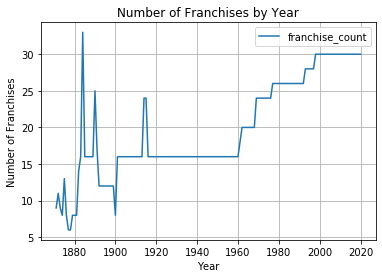

In [0]:
franchises_by_year = teams.groupBy('yearID').agg(expr('COUNT(DISTINCT franchID) AS franchise_count')).sort('yearID').toPandas()
plt.figure(figsize=(8,4))
franchises_by_year.plot(x='yearID', y='franchise_count')
plt.title("Number of Franchises by Year")
plt.xlabel("Year")
plt.ylabel("Number of Franchises")
plt.grid()
display(plt.show())

### B.2 – Franchise Statistics 
In this sub-section we will calculate statistics for each franchise.

In [0]:
franchise_summary = teams.groupBy('franchID')\
    .agg(expr('COUNT(DISTINCT name) AS num_names'),
        expr('MIN(yearID) AS first_year'),
        expr('MAX(yearID) AS last_year'),
        expr('COUNT(DISTINCT yearID) AS seasons'),
        expr('SUM(W) AS W'),
        expr('SUM(L) AS L'))\
    .withColumn('WL_ratio', expr('ROUND(W/L, 4)'))\
    .join(other=franchises, on='franchID', how='left')
print(f'The number of records in the franchise_summary dataframe is: {franchise_summary.count()}')
franchise_summary.show(10, truncate=False)

The number of records in the franchise_summary dataframe is: 120
+--------+---------+----------+---------+-------+----+----+--------+-------------------------+------+-------+
franchID|num_names|first_year|last_year|seasons|W |L |WL_ratio|franchName |active|NAassoc|
+--------+---------+----------+---------+-------+----+----+--------+-------------------------+------+-------+
NNA |1 |1871 |1875 |5 |151 |122 |1.2377 |New York Mutuals |NA |NYU |
PHA |1 |1882 |1890 |9 |560 |498 |1.1245 |Philadelphia Athletics |N |null |
NYM |1 |1962 |2020 |59 |4474|4842|0.924 |New York Mets |Y |null |
SNA |1 |1875 |1875 |1 |39 |29 |1.3448 |St. Louis Brown Stockings|NA |SBS |
BRA |1 |1872 |1875 |4 |50 |140 |0.3571 |Brooklyn Atlantics |NA |null |
CHP |1 |1890 |1890 |1 |75 |62 |1.2097 |Chicago Pirates |N |null |
SLR |1 |1875 |1875 |1 |4 |15 |0.2667 |St. Louis Red Stockings |NA |null |
OAK |3 |1901 |2020 |120 |9064|9476|0.9565 |Oakland Athletics |Y |null |
BWW |1 |1890 |1890 |1 |76 |56 |1.3571 |Brooklyn Ward's Wonders |N |null |
PBB |1 |1890 |1890 |1 |60 |68 |0.8824 |Pittsburgh Burghers |N |null |
+--------+---------+----------+---------+-------+----+----+--------+-------------------------+------+-------+
only showing top 10 rows

### B.3 – Franchises with the Most Names 
In the next cell we will determine that franchise that has gone by the most different names.

In [0]:
franchise_summary.sort('num_names', ascending=False).show(10, truncate=False)

+--------+---------+----------+---------+-------+-----+-----+--------+-----------------------------+------+-------+
franchID|num_names|first_year|last_year|seasons|W |L |WL_ratio|franchName |active|NAassoc|
+--------+---------+----------+---------+-------+-----+-----+--------+-----------------------------+------+-------+
LAD |8 |1884 |2020 |137 |11017|9835 |1.1202 |Los Angeles Dodgers |Y |null |
ATL |8 |1876 |2020 |145 |10732|10684|1.0045 |Atlanta Braves |Y |BNA |
CHC |4 |1876 |2020 |145 |11016|10430|1.0562 |Chicago Cubs |Y |CNA |
STL |4 |1882 |2020 |139 |10948|10091|1.0849 |St. Louis Cardinals |Y |null |
ANA |4 |1961 |2020 |60 |4735 |4753 |0.9962 |Los Angeles Angels of Anaheim|Y |null |
CLE |4 |1901 |2020 |120 |9512 |9062 |1.0497 |Cleveland Indians |Y |null |
CIN |3 |1882 |2020 |139 |10630|10422|1.02 |Cincinnati Reds |Y |null |
OAK |3 |1901 |2020 |120 |9064 |9476 |0.9565 |Oakland Athletics |Y |null |
BAL |3 |1901 |2020 |120 |8793 |9763 |0.9006 |Baltimore Orioles |Y |null |
SFG |3 |1883 |2020 |138 |11194|9718 |1.1519 |San Francisco Giants |Y |null |
+--------+---------+----------+---------+-------+-----+-----+--------+-----------------------------+------+-------+
only showing top 10 rows

In [0]:
teams.filter(expr('franchID=="LAD"')).groupBy('franchID', 'name').agg(expr('MIN(yearID) AS first_year'), expr('MAX(yearID) AS last_year')).sort('first_year').show()

+--------+--------------------+----------+---------+
franchID| name|first_year|last_year|
+--------+--------------------+----------+---------+
 LAD| Brooklyn Atlantics| 1884| 1884|
 LAD| Brooklyn Grays| 1885| 1887|
 LAD|Brooklyn Bridegrooms| 1888| 1898|
 LAD| Brooklyn Grooms| 1891| 1895|
 LAD| Brooklyn Superbas| 1899| 1913|
 LAD| Brooklyn Dodgers| 1911| 1957|
 LAD| Brooklyn Robins| 1914| 1931|
 LAD| Los Angeles Dodgers| 1958| 2020|
+--------+--------------------+----------+---------+

### B.4 – Age of Current Franchises 
In the next cell we will determine the age of the currently active franchises.

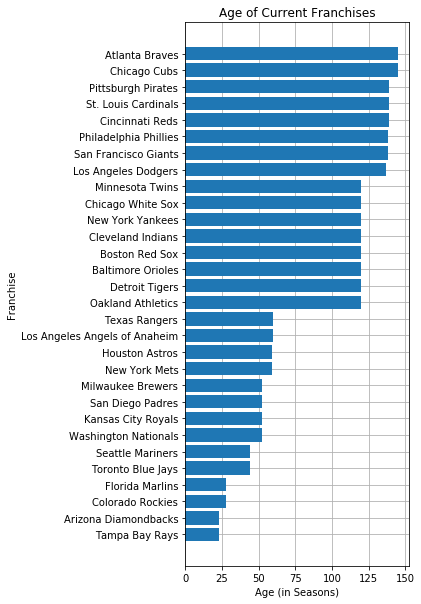

In [0]:
franchise_ages = franchise_summary.filter(expr('active == "Y"')).sort('seasons').toPandas()
plt.figure(figsize=(4,10))
plt.barh('franchName', 'seasons', data=franchise_ages, zorder=2)
plt.title("Age of Current Franchises")
plt.ylabel("Franchise")
plt.xlabel("Age (in Seasons)")
plt.grid()
display(plt.show())

### B.5 – Franchises with Best Win/Loss Ratios
In the next cell we will examine the win/loss ratios of different franchises and determine which franchises have the best ratios.

In [0]:
franchise_summary.sort('WL_ratio', ascending=False).select('franchID', 'franchName', 'seasons', 'first_year', 'last_year', 
'WL_ratio').show(10, truncate=False)

+--------+-------------------------+-------+----------+---------+--------+
franchID|franchName |seasons|first_year|last_year|WL_ratio|
+--------+-------------------------+-------+----------+---------+--------+
BNA |Boston Red Stockings |5 |1871 |1875 |3.75 |
MLU |Milwaukee Brewers |1 |1884 |1884 |2.0 |
BRS |Boston Reds |2 |1890 |1891 |1.9333 |
PNA |Philadelphia Athletics |5 |1871 |1875 |1.9186 |
COR |Cincinnati Outlaw Reds |1 |1884 |1884 |1.9167 |
HAR |Hartford Dark Blues |2 |1876 |1877 |1.625 |
PRO |Providence Grays |8 |1878 |1885 |1.5755 |
SBS |St. Louis Brown Stockings|2 |1876 |1877 |1.4314 |
MLA |Milwaukee Brewers |1 |1891 |1891 |1.4 |
BWW |Brooklyn Ward's Wonders |1 |1890 |1890 |1.3571 |
+--------+-------------------------+-------+----------+---------+--------+
only showing top 10 rows

### B.6 –Win/Loss Ratios in Recent Years 
As can be seen in the last sub-section, the franchises with the highest win/loss ratio are franchises from a long time ago, and which didn't play many seasons. In the next sub-section, we will analyze win/loss ratios only for the period from 1998 onward.

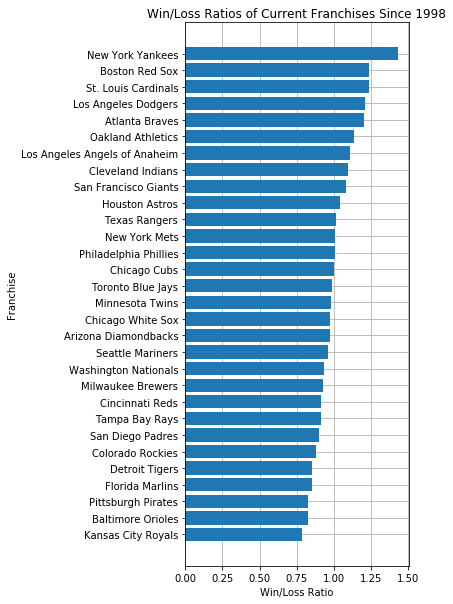

In [0]:
recent_WL = teams.filter(expr('yearID>=1998'))\
    .groupBy('franchID')\
    .agg(expr('SUM(W) AS W'), expr('SUM(L) AS L'))\
    .withColumn('WL_ratio', expr('ROUND(W/L, 4)'))\
    .join(other=franchises, on='franchID', how='left')\
    .sort('WL_ratio')\
    .toPandas()
plt.figure(figsize=(4,10))
plt.barh('franchName', 'WL_ratio', data=recent_WL, zorder=2)
plt.title("Win/Loss Ratios of Current Franchises Since 1998")
plt.ylabel("Franchise")
plt.xlabel("Win/Loss Ratio")
plt.grid()
display(plt.show())

## Section C – Batter Statistics 
In this section we will focus on career statistics for batters, particularly batting average and slugging percentage.

### C.1 – Calculating Career Statistics  
First we will need to calculate these career statistics by looking at the number of hits (and for slugging percentage the type of hits), and the total number of at-bats for a player. We will accomplish that in this sub-section.

In [0]:
batters = batting.groupBy('playerID')\
    .agg(expr('SUM(G) AS G'),
        expr('SUM(AB) AS AB'),
        expr('SUM(H) AS H'),
        expr('SUM(2B) AS 2B'),
        expr('SUM(3B) AS 3B'),
        expr('SUM(HR) AS HR'),
        expr('MIN(yearID) AS first_year'),
        expr('MAX(yearID) AS last_year'),
        expr('COUNT(DISTINCT yearID) AS seasons'))\
    .filter(expr('AB>=1'))\
    .withColumn('BA', expr('ROUND(H/AB, 4)'))\
    .withColumn('SP', expr('ROUND((H+2B+2*3B+3*HR)/AB, 4)'))\
    .join(other=people, on='playerID', how='inner')\
    .select('playerID', 'nameFirst', 'nameLast', 'first_year', 'last_year', 'seasons', 'height', 'weight', 'G', 'AB', 'H', '2B', '3B', 'HR', 'BA', 'SP')
print(f'There are {batters.count()} records in the batters dataframe.')
batters.show(10)

There are 17593 records in the batters dataframe.
+---------+---------+----------+----------+---------+-------+------+------+----+----+----+---+---+---+------+------+
 playerID|nameFirst| nameLast|first_year|last_year|seasons|height|weight| G| AB| H| 2B| 3B| HR| BA| SP|
+---------+---------+----------+----------+---------+-------+------+------+----+----+----+---+---+---+------+------+
gilliba01| Barney| Gilligan| 1879| 1888| 10| 66| 130| 521|1865| 386| 68| 23| 3| 0.207|0.2729|
steenmi01| Milt|Steengrafe| 1924| 1926| 2| 72| 170| 16| 15| 0| 0| 0| 0| 0.0| 0.0|
lefloro01| Ron| LeFlore| 1974| 1982| 9| 72| 200|1099|4458|1283|172| 57| 59|0.2878|0.3917|
simpsdi01| Dick| Simpson| 1962| 1969| 7| 76| 176| 288| 518| 107| 19| 2| 15|0.2066|0.3378|
johnswa01| Walter| Johnson| 1907| 1927| 21| 73| 200| 933|2324| 547| 94| 41| 24|0.2354|0.3421|
treshto01| Tom| Tresh| 1961| 1969| 9| 73| 180|1192|4251|1041|179| 34|153|0.2449| 0.411|
hansesn01| Snipe| Hansen| 1930| 1935| 5| 75| 195| 156| 200| 31| 3| 0| 0| 0.155| 0.17|
stobbch01| Chuck| Stobbs| 1947| 1961| 15| 73| 185| 460| 578| 102| 15| 0| 0|0.1765|0.2024|
heganmi01| Mike| Hegan| 1964| 1977| 12| 73| 188| 965|2080| 504| 73| 18| 53|0.2423|0.3712|
forscbo01| Bob| Forsch| 1974| 1989| 16| 76| 200| 509| 893| 190| 45| 8| 12|0.2128|0.3214|
+---------+---------+----------+----------+---------+-------+------+------+----+----+----+---+---+---+------+------+
only showing top 10 rows

### C.2 – Most Seasons Played 
In this sub-section we will determine which 10 batters played the most seasons.

In [0]:
batters.sort('seasons', ascending=False).select('nameFirst', 'nameLast', 'first_year', 'last_year', 'seasons').show(10)

+---------+---------+----------+---------+-------+
nameFirst| nameLast|first_year|last_year|seasons|
+---------+---------+----------+---------+-------+
 Nolan| Ryan| 1966| 1993| 27|
 Cap| Anson| 1871| 1897| 27|
 Deacon| McGuire| 1884| 1912| 26|
 Tommy| John| 1963| 1989| 26|
 Jim| Kaat| 1959| 1983| 25|
 Jamie| Moyer| 1986| 2012| 25|
 Bobby| Wallace| 1894| 1918| 25|
 Eddie| Collins| 1906| 1930| 25|
 Charlie| Hough| 1970| 1994| 25|
 Rickey|Henderson| 1979| 2003| 25|
+---------+---------+----------+---------+-------+
only showing top 10 rows

### C.3 – Most At-Bats 
In this sub-section we will determine which 10 batters had the most career at-bats.

In [0]:
batters.sort('AB', ascending=False).select('nameFirst', 'nameLast', 'seasons', 'AB').show(10)

+---------+-----------+-------+-----+
nameFirst| nameLast|seasons| AB|
+---------+-----------+-------+-----+
 Pete| Rose| 24|14053|
 Hank| Aaron| 23|12364|
 Carl|Yastrzemski| 23|11988|
 Cal| Ripken| 21|11551|
 Ty| Cobb| 24|11436|
 Eddie| Murray| 21|11336|
 Derek| Jeter| 20|11195|
 Adrian| Beltre| 21|11068|
 Robin| Yount| 20|11008|
 Dave| Winfield| 22|11003|
+---------+-----------+-------+-----+
only showing top 10 rows

### C.4 – Highest Batting Average 
In this sub-section we will determine the 10 players with the highest career batting averages (who have at least 100 at-bats).

In [0]:
batters.filter(expr('AB>=100')).sort('BA', ascending=False).select('nameFirst', 'nameLast', 'AB', 'BA').show(10)

+------------+---------+-----+------+
 nameFirst| nameLast| AB| BA|
+------------+---------+-----+------+
 Ty| Cobb|11436|0.3663|
 Ross| Barnes| 2391|0.3597|
 Rogers| Hornsby| 8173|0.3585|
Shoeless Joe| Jackson| 4981|0.3558|
 Levi| Meyerle| 1443|0.3555|
 Steve| King| 272|0.3529|
 Lefty| O'Doul| 3264|0.3493|
 George| Nicol| 147|0.3469|
 Ed|Delahanty| 7510|0.3458|
 Cal| McVey| 2513|0.3458|
+------------+---------+-----+------+
only showing top 10 rows

### C.5 – Highest Slugging Percentage 
We will now make the same determination with regards to slugging percentage.

In [0]:
batters.filter(expr('AB>=100')).sort('SP', ascending=False).select('nameFirst', 'nameLast', 'AB', 'SP').show(10)

+---------+---------+----+------+
nameFirst| nameLast| AB| SP|
+---------+---------+----+------+
 Babe| Ruth|8398|0.6898|
 Yordan| Alvarez| 321|0.6542|
 Edwin| Rios| 123|0.6341|
 Ted| Williams|7706|0.6338|
 Lou| Gehrig|8001|0.6324|
 Jimmie| Foxx|8134|0.6093|
 Barry| Bonds|9847|0.6069|
 Hank|Greenberg|5193| 0.605|
 John| Bass| 100| 0.6|
 Mark| McGwire|6187|0.5882|
+---------+---------+----+------+
only showing top 10 rows

### C.6 – Relationship between Batting Average and Slugging Percentage 
In this sub-section we will generate a visualization based on a random sample to show the relationship between batting average and slugging percentage.

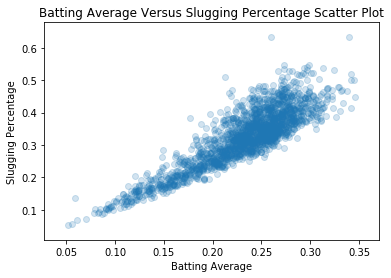

In [0]:
batters_sample = batters.filter(expr('AB>=100')).sample(withReplacement=False, fraction=0.2, seed=1).toPandas()
plt.scatter(batters_sample['BA'], batters_sample['SP'], alpha=0.2)
plt.xlabel('Batting Average')
plt.ylabel('Slugging Percentage')
plt.title('Batting Average Versus Slugging Percentage Scatter Plot')
plt.show()

## Section D – Trends over Time 
In this section we will look at how some statistics have changed over time during the history of baseball.

### D.1 – Calculating Averages by Year 
First we will calculate the batting averages and slugging percentages over the years.

In [0]:
by_year = batting.join(other=people, on='playerID', how='inner')\
    .groupBy('yearID')\
    .agg(expr('AVG(weight) AS avg_wt'),
         expr('AVG(height) AS avg_ht'),
         expr('SUM(AB) AS AB'),
         expr('SUM(H) AS H'),
         expr('SUM(2B) AS 2B'),
         expr('SUM(3B) AS 3B'),
         expr('SUM(HR) AS HR'))\
    .withColumn('BA', expr('ROUND(H/AB, 4)'))\
    .withColumn('SP', expr('ROUND((H+2B+2*3B+3*HR)/AB, 4)'))\
    .sort('yearID')\
    .toPandas()
by_year.head()

,yearID,avg_wt,avg_ht,AB,H,2B,3B,HR,BA,SP
0,1871,157.049505,68.509804,10822,3101,434,239,47,0.2865,0.3838
1,1872,159.847458,68.533333,15665,4467,581,145,37,0.2852,0.3478
2,1873,160.236559,68.612903,16959,4926,570,211,47,0.2905,0.3573
3,1874,161.075269,68.582418,19104,5224,634,194,40,0.2735,0.3332
4,1875,162.269461,68.725610,26833,6812,839,273,40,0.2539,0.3100


### D.2 – Trends for Height and Weight 
In this sub-section we will look at how average heights and weights have changed over the years.

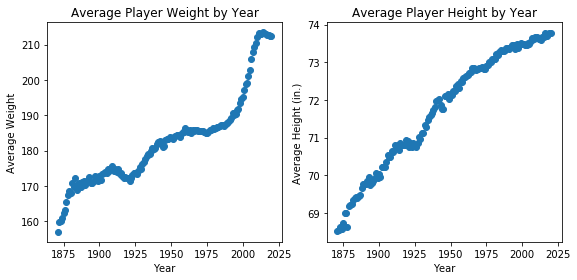

In [0]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(by_year['yearID'], by_year['avg_wt'])
plt.xlabel('Year')
plt.ylabel('Average Weight')
plt.title('Average Player Weight by Year')
plt.subplot(1,2,2)
plt.scatter(by_year['yearID'], by_year['avg_ht'])
plt.xlabel('Year')
plt.ylabel('Average Height (in.)')
plt.title('Average Player Height by Year')
plt.tight_layout()
plt.show()

### D.3 – Trends for Batting Statistics 
Now we will look at trends for batting statistics over the years.

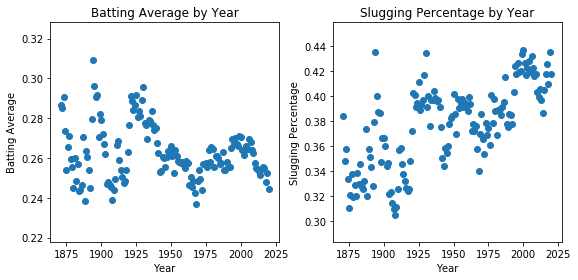

In [0]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(by_year['yearID'], by_year['BA'])
plt.xlabel('Year')
plt.ylabel('Batting Average')
plt.title('Batting Average by Year')
plt.subplot(1,2,2)
plt.scatter(by_year['yearID'], by_year['SP'])
plt.xlabel('Year')
plt.ylabel('Slugging Percentage')
plt.title('Slugging Percentage by Year')
plt.tight_layout()
plt.show()

### D.4 – Trends for American and National Leagues 
In this sub-section, we will look at similar trends as in the last two sub-sections, but we will also divide the results by league, and limit the results to years 1960 and onwards.

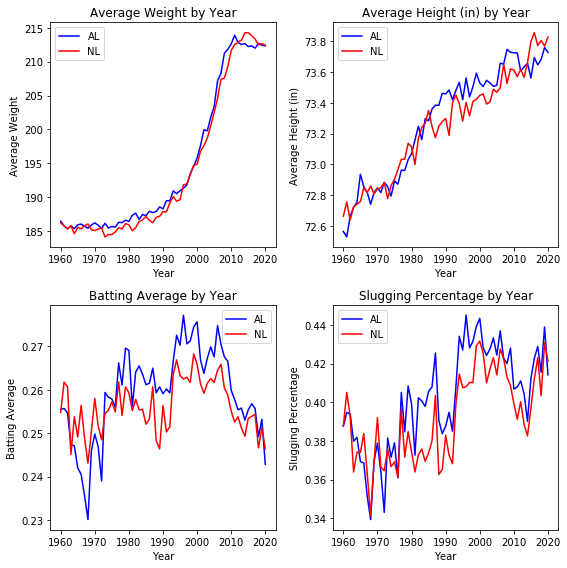

In [0]:
by_year_and_league = batting.join(other=people, on='playerID', how='inner')\
    .filter(expr('yearID>=1960'))\
    .groupBy('yearID', 'lgID')\
    .agg(expr('AVG(weight) AS avg_wt'),
         expr('AVG(height) AS avg_ht'),
         expr('SUM(AB) AS AB'),
         expr('SUM(H) AS H'),
         expr('SUM(2B) AS 2B'),
         expr('SUM(3B) AS 3B'),
         expr('SUM(HR) AS HR'))\
    .withColumn('BA', expr('ROUND(H/AB, 4)'))\
    .withColumn('SP', expr('ROUND((H+2B+2*3B+3*HR)/AB, 4)'))\
    .sort('yearID')
american_league = by_year_and_league.filter(expr('lgID=="AL"')).toPandas()
national_league = by_year_and_league.filter(expr('lgID=="NL"')).toPandas()

y_list = ['avg_wt', 'avg_ht', 'BA', 'SP']
y_labels = ['Average Weight', 'Average Height (in)', 'Batting Average', 'Slugging Percentage']


plt.figure(figsize=(8,8))
for x in range(1,5):
    plt.subplot(2,2,x)
    plt.plot(american_league['yearID'], american_league[y_list[x-1]], color='blue', label='AL')
    plt.plot(national_league['yearID'], national_league[y_list[x-1]], color='red', label='NL')
    plt.xlabel('Year')
    plt.ylabel(y_labels[x-1])
    plt.title(f'{y_labels[x-1]} by Year')
    plt.legend()

plt.tight_layout()
plt.show()

### D.5 – Average Number of Games 
In this sub-section, we will determine the average number of games played per team each season.

In [0]:
games_per_season = teams.groupBy('yearID')\
    .agg(expr('SUM(G) as G'), 
         expr('COUNT(DISTINCT franchID) AS num_franch'))\
    .withColumn('avg_games', expr('ROUND(G/num_franch, 1)'))\
    .sort('yearID')\
    .toPandas()
games_per_season.head()

,yearID,G,num_franch,avg_games
0,1871,254,9,28.2
1,1872,366,11,33.3
2,1873,398,9,44.2
3,1874,464,8,58.0
4,1875,690,13,53.1


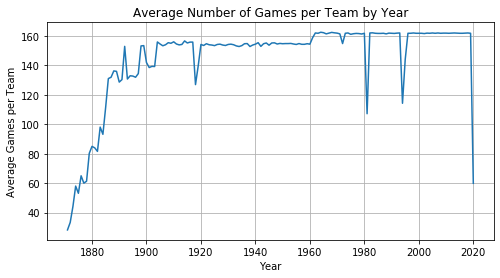

In [0]:
plt.figure(figsize=(8,4))
plt.plot(games_per_season['yearID'], games_per_season['avg_games'])
plt.title('Average Number of Games per Team by Year')
plt.xlabel('Year')
plt.ylabel('Average Games per Team')
plt.grid()
plt.show()

## Section E – Homerun Analysis